<a href="https://colab.research.google.com/github/joaopb0/AnaliseDeDadosIA/blob/main/Previs%C3%A3o_de_AVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import os #Verificar os arquivos disponiveis no diretório do dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

Importação do dataset do Kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")

print("Path to dataset files:", path)

100%|██████████| 67.4k/67.4k [00:00<00:00, 45.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/fedesoriano/stroke-prediction-dataset/versions/1


In [ ]:
print("Arquivos disponíveis:")
print(os.listdir(path))

Arquivos disponíveis:
['healthcare-dataset-stroke-data.csv']


In [ ]:
csv_path = os.path.join(path, "healthcare-dataset-stroke-data.csv")
df = pd.read_csv(csv_path)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Pré processamento dos dados

In [ ]:
num_linhas = df.shape[0]
print("Número de linhas do dataset:", num_linhas)

Número de linhas do dataset: 5110


In [ ]:
df.isnull().sum() #Verificar valores nulos para o pré processamento dos dados

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


In [ ]:
# Verificar se pessoas com idade insuficiente estão casadas
df[(df['age'] <= 17) & (df['ever_married'] == 'Yes')]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [ ]:
#Verificar se pessoas com idade insuficiente estão classificadas como se trabalhassem
df[(df['age'] <= 13) & (df['work_type'].isin(['Self-employed', 'Private', 'Govt_job']))]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
251,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,Unknown,0
410,54975,Male,7.0,0,0,No,Self-employed,Rural,64.06,18.9,Unknown,0
455,7351,Male,13.0,0,0,No,Private,Urban,92.14,23.2,never smoked,0
1063,42821,Female,13.0,0,0,No,Private,Rural,60.69,24.0,smokes,0
1809,18179,Male,13.0,0,0,No,Private,Rural,99.44,21.0,never smoked,0
1976,46577,Female,13.0,0,0,No,Private,Urban,77.63,31.7,never smoked,0
2112,9199,Male,13.0,0,0,No,Self-employed,Urban,74.19,31.1,formerly smoked,0
3334,56282,Male,13.0,0,0,No,Private,Rural,90.60,16.9,never smoked,0
3414,60249,Male,13.0,0,0,No,Private,Urban,141.09,24.0,Unknown,0
3486,70833,Female,13.0,0,0,No,Private,Urban,62.57,20.9,Unknown,0


In [ ]:
df.loc[df['age'] <= 13, 'work_type'] = 'children' #Tratar pessoas que não tem idade para trabalhar

In [ ]:
#Verificar se pessoas com idade insuficiente estão classificadas como se trabalhassem
df[(df['age'] <= 13) & (df['work_type'].isin(['Self-employed', 'Private', 'Govt_job']))]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [ ]:
df = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']]

In [ ]:
median_bmi = df['bmi'].median()
df['bmi'].fillna(median_bmi, inplace=True) #Substituição dos valores nulos do indice de massa corporal por mediana

<ipython-input-12-fb9573290e74>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(median_bmi, inplace=True) #Substituição dos valores nulos do indice de massa corporal por mediana


In [ ]:
df.isnull().sum() #Verificar se há algum valor nulo pendente

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


In [ ]:
df.shape

(5110, 11)

In [ ]:
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
df['gender'] = df['gender'].fillna(0).astype(int) #Converte para numero inteiro

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,1,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,0,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,1,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df['ever_married'] = df['ever_married'].map({'Yes': 0, 'No': 1})
df['ever_married'] = df['ever_married'].fillna(0).astype(int) #Converte para inteiro

In [ ]:
df['heart_disease'] = df['heart_disease'].fillna(0).astype(int) #Converte para numero inteiro

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,0,Private,Urban,228.69,36.6,formerly smoked,1
1,1,61.0,0,0,0,Self-employed,Rural,202.21,28.1,never smoked,1
2,0,80.0,0,1,0,Private,Rural,105.92,32.5,never smoked,1
3,1,49.0,0,0,0,Private,Urban,171.23,34.4,smokes,1
4,1,79.0,1,0,0,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df['hypertension'] = df['hypertension'].fillna(0).astype(int) #Converte para numero inteiro

In [ ]:
df['stroke'] = df['stroke'].fillna(0).astype(int) #Converte para numero inteiro

In [ ]:
df['work_type'].unique() #Verifica todos os valores de tipo de trabalho

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [ ]:
df['work_type'] = df['work_type'].map({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})
df['work_type'] = df['work_type'].fillna(0).astype(int) #Converte para inteiro

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,0,0,Urban,228.69,36.6,formerly smoked,1
1,1,61.0,0,0,0,1,Rural,202.21,28.1,never smoked,1
2,0,80.0,0,1,0,0,Rural,105.92,32.5,never smoked,1
3,1,49.0,0,0,0,0,Urban,171.23,34.4,smokes,1
4,1,79.0,1,0,0,1,Rural,174.12,24.0,never smoked,1


In [ ]:
df['work_type'].unique() #Verifica se todos os valores foram alterados para numeros

array([0, 1, 2, 3, 4])

In [ ]:
df['Residence_type'] = df['Residence_type'].map({'Urban': 0, 'Rural': 1})
df['Residence_type'] = df['Residence_type'].fillna(0).astype(int) #Converte para inteiro

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,0,0,0,228.69,36.6,formerly smoked,1
1,1,61.0,0,0,0,1,1,202.21,28.1,never smoked,1
2,0,80.0,0,1,0,0,1,105.92,32.5,never smoked,1
3,1,49.0,0,0,0,0,0,171.23,34.4,smokes,1
4,1,79.0,1,0,0,1,1,174.12,24.0,never smoked,1


In [ ]:
df['smoking_status'].unique() #Verifica os valores da coluna se a pessoa fuma ou não

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [ ]:
df['smoking_status'] = df['smoking_status'].map({'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3})
df['smoking_status'] = df['smoking_status'].fillna(0).astype(int) #Converte para inteiro

In [ ]:
df['smoking_status'].unique() #Verifica os valores da coluna se a pessoa fuma ou não

array([0, 1, 2, 3])

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,0,0,0,228.69,36.6,0,1
1,1,61.0,0,0,0,1,1,202.21,28.1,1,1
2,0,80.0,0,1,0,0,1,105.92,32.5,1,1
3,1,49.0,0,0,0,0,0,171.23,34.4,2,1
4,1,79.0,1,0,0,1,1,174.12,24.0,1,1


Geração de gráficos e treinamento

<ipython-input-32-6b58ff1d0087>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='stroke', data=df, palette=cores)


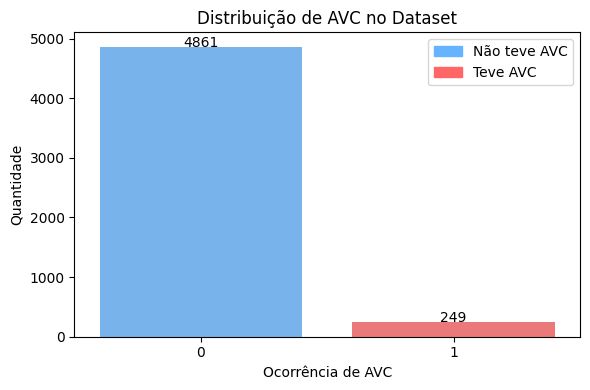

In [ ]:
cores = ['#66b3ff', '#ff6666']

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='stroke', data=df, palette=cores)

plt.title("Distribuição de AVC no Dataset")
plt.xlabel("Ocorrência de AVC")
plt.ylabel("Quantidade")

# Adiciona números totais acima das barras
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5,
            int(height), ha="center", fontsize=10)

handles = [plt.Rectangle((0,0),1,1, color=cor) for cor in cores]
labels = ['Não teve AVC', 'Teve AVC']
ax.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

<ipython-input-33-221b83b8d313>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='hypertension', data=df, palette=cores)


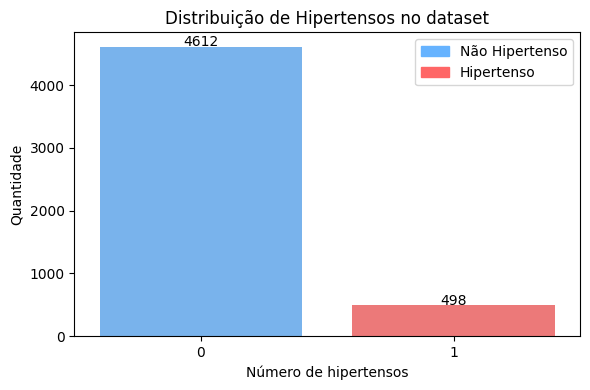

In [ ]:
cores = ['#66b3ff', '#ff6666']

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='hypertension', data=df, palette=cores)

plt.title("Distribuição de Hipertensos no dataset")
plt.xlabel("Número de hipertensos")
plt.ylabel("Quantidade")

# Adiciona números totais acima das barras
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5,
            int(height), ha="center", fontsize=10)

handles = [plt.Rectangle((0,0),1,1, color=cor) for cor in cores]
labels = ['Não Hipertenso', 'Hipertenso']
ax.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

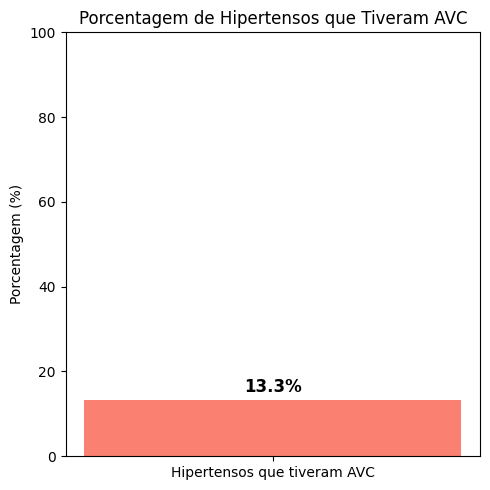

In [ ]:
hipertensos = df[df['hypertension'] == 1]
porcentagem = (hipertensos['stroke'].sum() / len(hipertensos)) * 100

# Criação do gráfico
plt.figure(figsize=(5, 5))
plt.bar(['Hipertensos que tiveram AVC'], [porcentagem], color='salmon')
plt.ylim(0, 100)
plt.ylabel('Porcentagem (%)')
plt.title('Porcentagem de Hipertensos que Tiveram AVC')

# Adiciona a porcentagem acima da barra
plt.text(0, porcentagem + 2, f'{porcentagem:.1f}%', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

<ipython-input-35-667047a6c993>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='heart_disease', data=df, palette=cores)


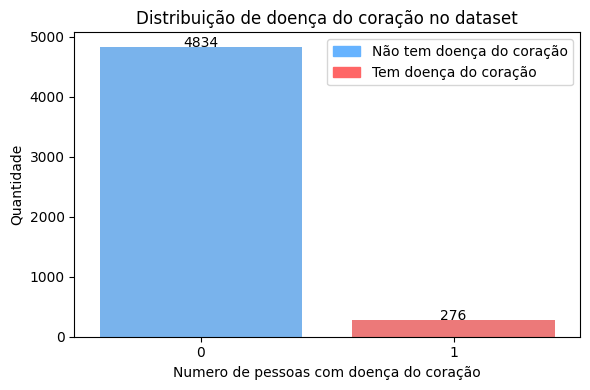

In [ ]:
cores = ['#66b3ff', '#ff6666']

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='heart_disease', data=df, palette=cores)

plt.title("Distribuição de doença do coração no dataset")
plt.xlabel("Numero de pessoas com doença do coração")
plt.ylabel("Quantidade")

# Adiciona números totais acima das barras
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5,
            int(height), ha="center", fontsize=10)

handles = [plt.Rectangle((0,0),1,1, color=cor) for cor in cores]
labels = ['Não tem doença do coração', 'Tem doença do coração']
ax.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

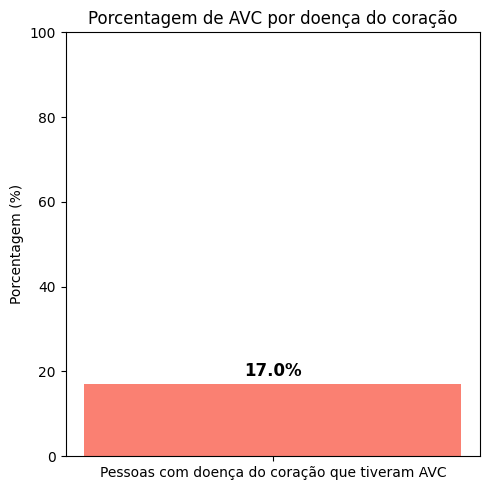

In [ ]:
doencacoracao = df[df['heart_disease'] == 1]
porcentagem = (doencacoracao['stroke'].sum() / len(doencacoracao)) * 100

# Criação do gráfico
plt.figure(figsize=(5, 5))
plt.bar(['Pessoas com doença do coração que tiveram AVC'], [porcentagem], color='salmon')
plt.ylim(0, 100)
plt.ylabel('Porcentagem (%)')
plt.title('Porcentagem de AVC por doença do coração')

# Adiciona porcentagem acima da barra
plt.text(0, porcentagem + 2, f'{porcentagem:.1f}%', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

<ipython-input-40-5499e14b4dd9>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='ever_married', data=df, palette=cores)


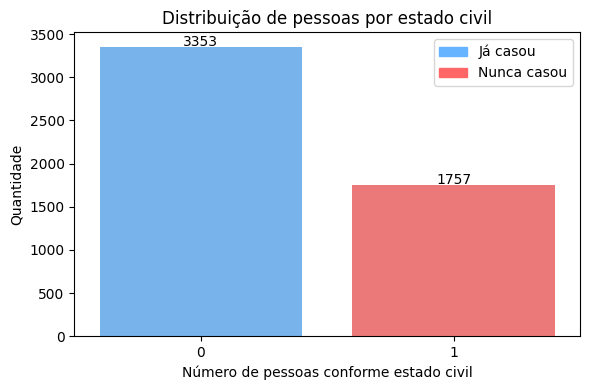

In [ ]:
cores = ['#66b3ff', '#ff6666']

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='ever_married', data=df, palette=cores)

plt.title("Distribuição de pessoas por estado civil")
plt.xlabel("Número de pessoas conforme estado civil")
plt.ylabel("Quantidade")

# Adiciona números totais acima das barras
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5,
            int(height), ha="center", fontsize=10)

handles = [plt.Rectangle((0,0),1,1, color=cor) for cor in cores]
labels = ['Já casou', 'Nunca casou']
ax.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
counts = df.groupby(['ever_married', 'stroke']).size().unstack(fill_value=0)

percentages = counts.div(counts.sum(axis=1), axis=0) * 100  #Porcentagem de pessoas pelo estado civil que tiveram avc

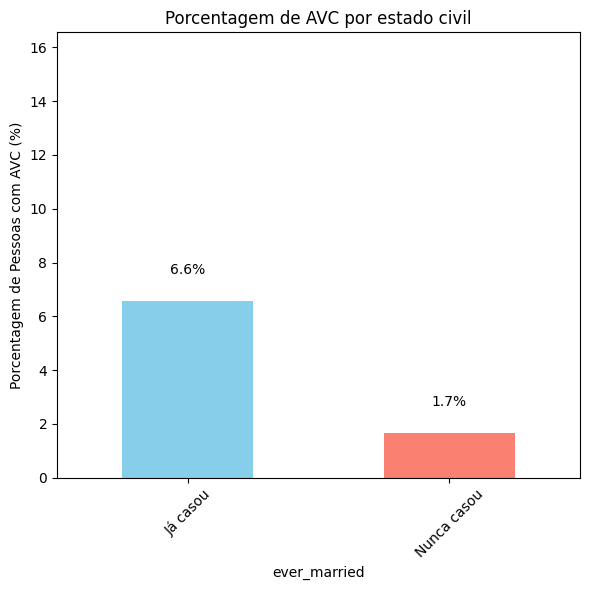

In [ ]:
stroke_perc = percentages[1]

stroke_perc.index = stroke_perc.index.map({0: 'Já casou', 1: 'Nunca casou'})

fig, ax = plt.subplots(figsize=(6, 6))

stroke_perc.plot(kind='bar', color=['skyblue', 'salmon'], ax=ax)

ax.set_ylim(0, stroke_perc.max() + 10)

plt.xticks(rotation=45)
plt.ylabel('Porcentagem de Pessoas com AVC (%)')
plt.title('Porcentagem de AVC por estado civil')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 1,
        f'{height:.1f}%',
        ha='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()


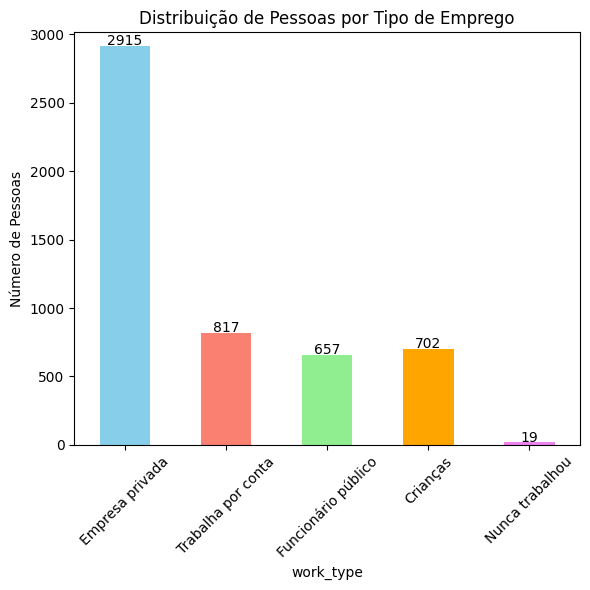

In [ ]:
counts = df['work_type'].value_counts().sort_index()

counts.index = counts.index.map({
    0: 'Empresa privada',
    1: 'Trabalha por conta',
    2: 'Funcionário público',
    3: 'Crianças',
    4: 'Nunca trabalhou'
})

fig, ax = plt.subplots(figsize=(6, 6))
counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'orange', 'violet'], ax=ax)

ax.set_ylim(0, counts.max() + 100)
plt.xticks(rotation=45)
plt.ylabel('Número de Pessoas')
plt.title('Distribuição de Pessoas por Tipo de Emprego')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{int(height)}',
            ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
counts = df.groupby(['work_type', 'stroke']).size().unstack(fill_value=0)

percentages = counts.div(counts.sum(axis=1), axis=0) * 100  #Porcentagem de pessoas pelo tipo de trabalho que tiveram AVC

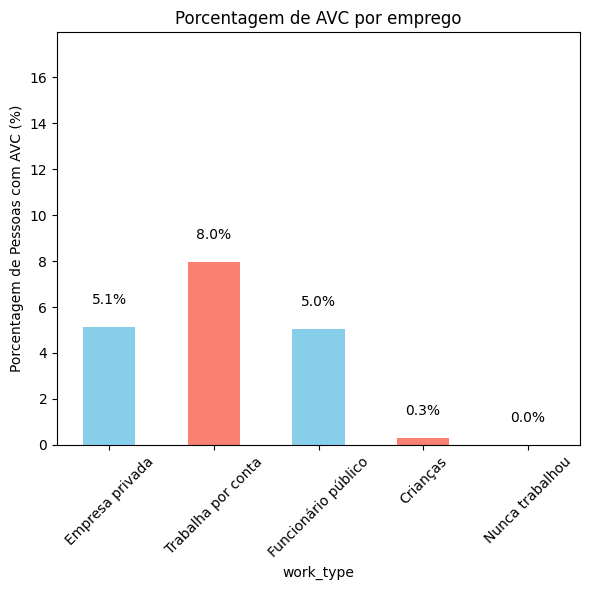

In [ ]:
stroke_perc = percentages[1]

stroke_perc.index = stroke_perc.index.map({0: 'Empresa privada', 1: 'Trabalha por conta', 2:'Funcionário público', 3:'Crianças', 4:'Nunca trabalhou'})

fig, ax = plt.subplots(figsize=(6, 6))

stroke_perc.plot(kind='bar', color=['skyblue', 'salmon'], ax=ax)

ax.set_ylim(0, stroke_perc.max() + 10)

plt.xticks(rotation=45)
plt.ylabel('Porcentagem de Pessoas com AVC (%)')
plt.title('Porcentagem de AVC por emprego')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 1,
        f'{height:.1f}%',
        ha='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()

<ipython-input-68-a96bda410151>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Residence_type', data=df, palette=cores)


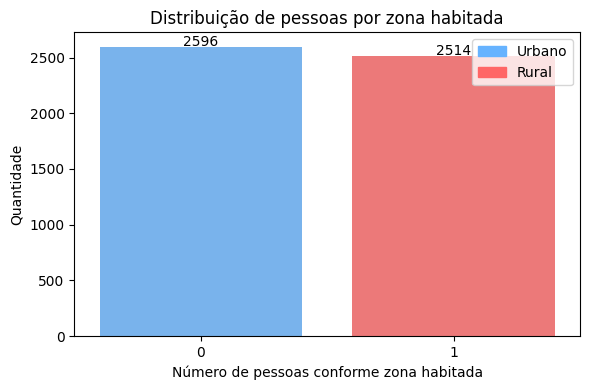

In [ ]:
cores = ['#66b3ff', '#ff6666']

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Residence_type', data=df, palette=cores)

plt.title("Distribuição de pessoas por zona habitada")
plt.xlabel("Número de pessoas conforme zona habitada")
plt.ylabel("Quantidade")

# Adiciona números totais acima das barras
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5,
            int(height), ha="center", fontsize=10)

handles = [plt.Rectangle((0,0),1,1, color=cor) for cor in cores]
labels = ['Urbano', 'Rural']
ax.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
counts = df.groupby(['Residence_type', 'stroke']).size().unstack(fill_value=0)

percentages = counts.div(counts.sum(axis=1), axis=0) * 100 #Porcentagem de pessoas por tipo de zona em que residem que tiveram AVC

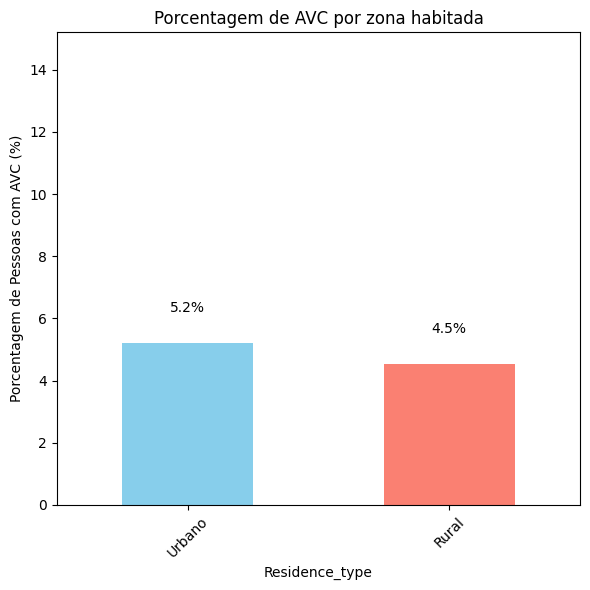

In [ ]:
stroke_perc = percentages[1]

stroke_perc.index = stroke_perc.index.map({0: 'Urbano', 1: 'Rural'})

fig, ax = plt.subplots(figsize=(6, 6))

stroke_perc.plot(kind='bar', color=['skyblue', 'salmon'], ax=ax)

ax.set_ylim(0, stroke_perc.max() + 10)

plt.xticks(rotation=45)
plt.ylabel('Porcentagem de Pessoas com AVC (%)')
plt.title('Porcentagem de AVC por zona habitada')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 1,
        f'{height:.1f}%',
        ha='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()


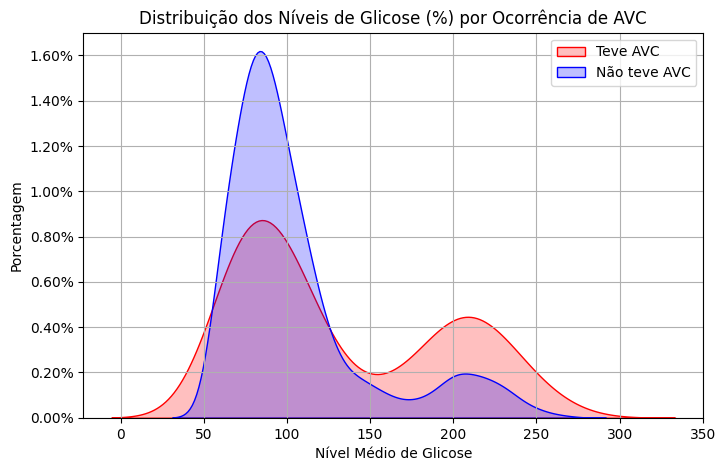

In [ ]:
glucose_stroke = df[df['stroke'] == 1]['avg_glucose_level']
glucose_no_stroke = df[df['stroke'] == 0]['avg_glucose_level']

plt.figure(figsize=(8, 5))

sns.kdeplot(glucose_stroke, fill=True, color='red', label='Teve AVC', common_norm=False)
sns.kdeplot(glucose_no_stroke, fill=True, color='blue', label='Não teve AVC', common_norm=False)

plt.title('Distribuição dos Níveis de Glicose (%) por Ocorrência de AVC')
plt.xlabel('Nível Médio de Glicose')
plt.ylabel('Porcentagem')

plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))

plt.legend()
plt.grid(True)
plt.show()

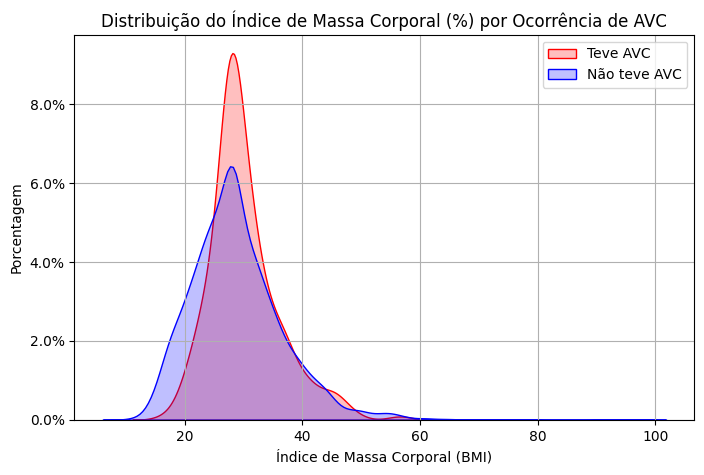

In [ ]:
bmi_stroke = df[df['stroke'] == 1]['bmi']
bmi_no_stroke = df[df['stroke'] == 0]['bmi']

plt.figure(figsize=(8, 5))

sns.kdeplot(bmi_stroke, fill=True, color='red', label='Teve AVC', common_norm=False)
sns.kdeplot(bmi_no_stroke, fill=True, color='blue', label='Não teve AVC', common_norm=False)

plt.title('Distribuição do Índice de Massa Corporal (%) por Ocorrência de AVC')
plt.xlabel('Índice de Massa Corporal (BMI)')
plt.ylabel('Porcentagem')

plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))

plt.legend()
plt.grid(True)
plt.show()


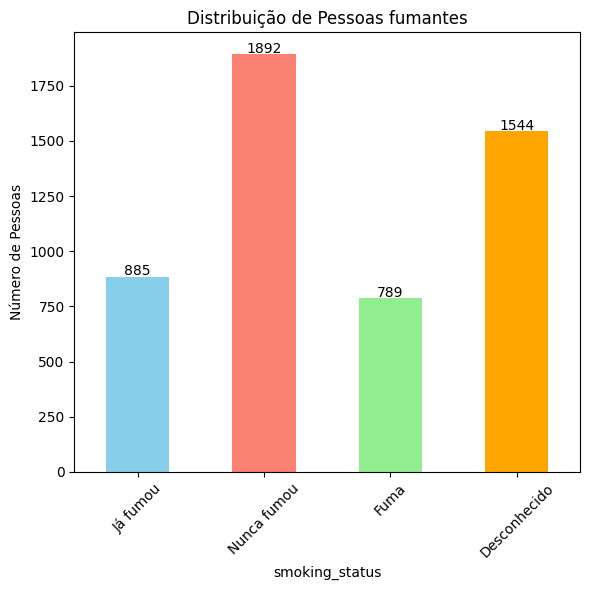

In [ ]:
counts = df['smoking_status'].value_counts().sort_index()

# Mapeia para nomes legíveis
counts.index = counts.index.map({
    0: 'Já fumou',
    1: 'Nunca fumou',
    2: 'Fuma',
    3: 'Desconhecido',
})

# Plotar gráfico
fig, ax = plt.subplots(figsize=(6, 6))
counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'orange'], ax=ax)

ax.set_ylim(0, counts.max() + 100)
plt.xticks(rotation=45)
plt.ylabel('Número de Pessoas')
plt.title('Distribuição de Pessoas fumantes')

# Adiciona os valores em cima das barras
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{int(height)}',
            ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
counts = df.groupby(['smoking_status', 'stroke']).size().unstack(fill_value=0)

percentages = counts.div(counts.sum(axis=1), axis=0) * 100  #Porcentagem de pessoas se fumavam ou não se tiveram AVC

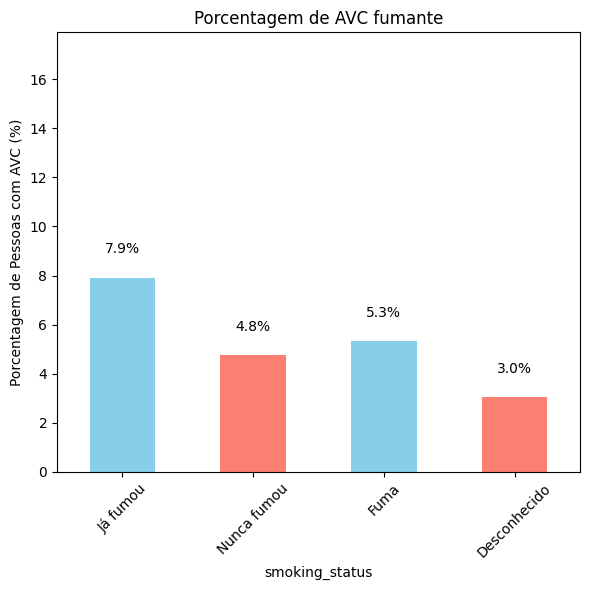

In [ ]:
stroke_perc = percentages[1]

stroke_perc.index = stroke_perc.index.map({0: 'Já fumou', 1: 'Nunca fumou', 2:'Fuma', 3:'Desconhecido'})

fig, ax = plt.subplots(figsize=(6, 6))

stroke_perc.plot(kind='bar', color=['skyblue', 'salmon'], ax=ax)

ax.set_ylim(0, stroke_perc.max() + 10)

plt.xticks(rotation=45)
plt.ylabel('Porcentagem de Pessoas com AVC (%)')
plt.title('Porcentagem de AVC fumante')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 1,
        f'{height:.1f}%',
        ha='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [ ]:
# Fatores de risco já existentes
risco_hipertensao = df['hypertension'] == 1
risco_cardiaco = df['heart_disease'] == 1
risco_glicose = df['avg_glucose_level'] > 140 #Baseado na medição de glicose dos Estados Unidos
risco_bmi = df['bmi'] >= 30
risco_fumante = df['smoking_status'].isin([0, 2])  # 0 já fumou e 2 fuma atualmente

# Combinação dos fatores de risco
tem_fator_de_risco = risco_hipertensao | risco_cardiaco | risco_glicose | risco_bmi | risco_fumante

# Filtrar apenas quem teve AVC
teve_avc = df['stroke'] == 1

# Dividir em com e sem fatores de risco
com_risco = df[teve_avc & tem_fator_de_risco]
sem_risco = df[teve_avc & ~tem_fator_de_risco]

# Dados para o gráfico
valores = [len(com_risco), len(sem_risco)]
labels = ['Com 1 ou mais fatores de risco', 'Sem fatores de risco']
cores = ['#ff9999', '#66b3ff']

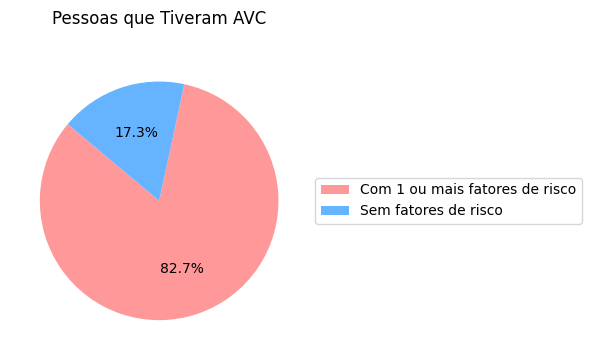

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(valores, autopct='%1.1f%%', colors=cores, startangle=140)

# Espaçar o titulo
ax.set_title('Pessoas que Tiveram AVC', pad=20)

# Legenda ao lado
ax.legend(wedges, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,0,0,0,228.69,36.6,0,1
1,1,61.0,0,0,0,1,1,202.21,28.1,1,1
2,0,80.0,0,1,0,0,1,105.92,32.5,1,1
3,1,49.0,0,0,0,0,0,171.23,34.4,2,1
4,1,79.0,1,0,0,1,1,174.12,24.0,1,1


In [ ]:
X = df.drop('stroke', axis=1) #Dados previsores de entrada
y = df['stroke'] #Prever se teve um AVC ou não

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
preverAVCsemregular = Sequential()
preverAVCsemregular.add(Dense(units=15, activation='relu', input_dim=X_train.shape[1]))
preverAVCsemregular.add(Dense(units=10, activation='relu'))
preverAVCsemregular.add(Dense(units=5, activation='relu'))
preverAVCsemregular.add(Dense(units=2, activation='relu'))
preverAVCsemregular.add(Dense(units=1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
preverAVCsemregular.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_preverAVCsemregular = preverAVCsemregular.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9529 - loss: 0.4144 - val_accuracy: 0.9419 - val_loss: 0.3074
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9587 - loss: 0.2283 - val_accuracy: 0.9419 - val_loss: 0.2753
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9550 - loss: 0.2265 - val_accuracy: 0.9419 - val_loss: 0.2504
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9491 - loss: 0.2189 - val_accuracy: 0.9419 - val_loss: 0.2226
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9616 - loss: 0.1698 - val_accuracy: 0.9419 - val_loss: 0.2083
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9576 - loss: 0.1634 - val_accuracy: 0.9419 - val_loss: 0.2279
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9608 - loss: 0.1546 - val_accuracy: 0.9419 - val_loss: 0.1921
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9607 - loss: 0.1479 - val_accu

In [ ]:
y_pred_probs = preverAVCsemregular.predict(X_test)

# Se for maior que 0.5 vira verdadeiro (1)
# Se for menor que 0.5 vira falso (0)
#Transforma em numero inteiro
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Cria a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


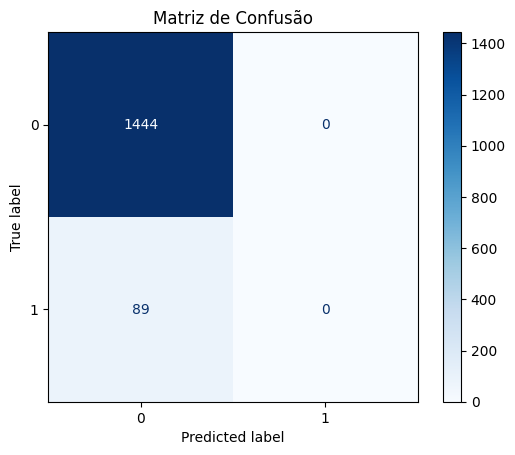

In [ ]:
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia total do modelo: {accuracy * 100:.2f}%")

Acurácia total do modelo: 94.19%


In [ ]:
tn, fp, fn, tp = cm.ravel()

# Percentuais de acerto por classe
acerto_0 = tn / (tn + fp) * 100  # Classe 0: sem AVC
acerto_1 = tp / (tp + fn) * 100  # Classe 1: com AVC

In [ ]:
labels = ['Não teve AVC (Classe 0)', 'Teve AVC (Classe 1)']
valores = [acerto_0, acerto_1]

<ipython-input-301-3573141709>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=valores, palette='Blues_d')


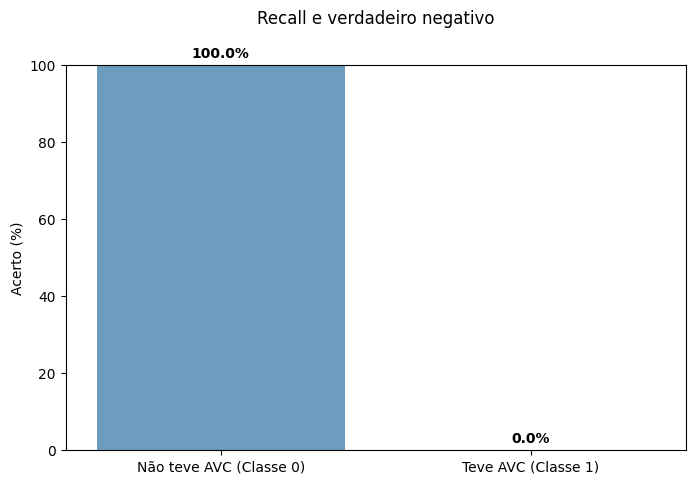

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x=labels, y=valores, palette='Blues_d')
plt.ylabel('Acerto (%)')
plt.title('Recall e verdadeiro negativo', pad=30)
plt.ylim(0, 100)
for i, v in enumerate(valores):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

In [ ]:
erro_0 = fp / (tn + fp) * 100  # Classe 0: previu AVC, mas não teve AVC
erro_1 = fn / (tp + fn) * 100  # Classe 1: previu não teve AVC, mas teve AVC

In [ ]:
labels = ['Não teve AVC (Classe 0)', 'Teve AVC (Classe 1)']
valores = [erro_0, erro_1]

<ipython-input-304-3033111984>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=valores, palette='Reds')


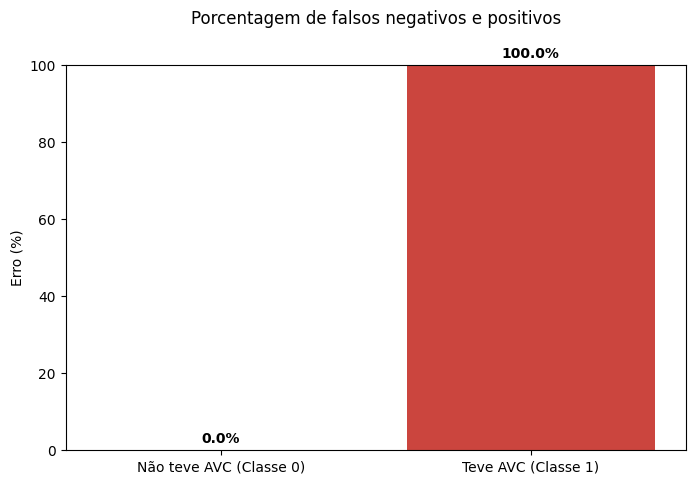

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x=labels, y=valores, palette='Reds')
plt.ylabel('Erro (%)')
plt.title('Porcentagem de falsos negativos e positivos', pad=30)
plt.ylim(0, 100)
for i, v in enumerate(valores):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#Padroniza os valores de X (previsores) para otimizar o treinamento

In [ ]:
preverAVC = Sequential()
preverAVC.add(Dense(units=15, activation='elu', input_dim=X_train.shape[1]))
preverAVC.add(Dropout(0.3))  # Desativa 30% dos neuronios
preverAVC.add(Dense(units=10, activation='relu'))
preverAVC.add(Dense(units=5, activation='relu'))
preverAVC.add(Dense(units=2, activation='relu'))
preverAVC.add(Dense(units=1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Ajustar o peso das classes automaticamente para evitar que o AVC de falso negativo
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

In [ ]:
preverAVC.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_preverAVC = preverAVC.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping], class_weight=class_weights, verbose=1)

Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1369 - loss: 0.8064 - val_accuracy: 0.5088 - val_loss: 0.7497
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4632 - loss: 0.6573 - val_accuracy: 0.6458 - val_loss: 0.7443
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5614 - loss: 0.6241 - val_accuracy: 0.6719 - val_loss: 0.7421
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6301 - loss: 0.6393 - val_accuracy: 0.6699 - val_loss: 0.7409
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6254 - loss: 0.6358 - val_accuracy: 0.7012 - val_loss: 0.7112
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6777 - loss: 0.6341 - val_accuracy: 0.6960 - val_loss: 0.6999
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6762 - loss: 0.5869 - val_accuracy: 0.6941 - val_loss: 0.6995
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6858 - loss: 0.5870 - val_accu

In [ ]:
y_pred_probs = preverAVC.predict(X_test)

# Se for maior que 0.5 vira verdadeiro (1)
# Se for menor que 0.5 vira falso (0)
#Transforma em numero inteiro
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Cria a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


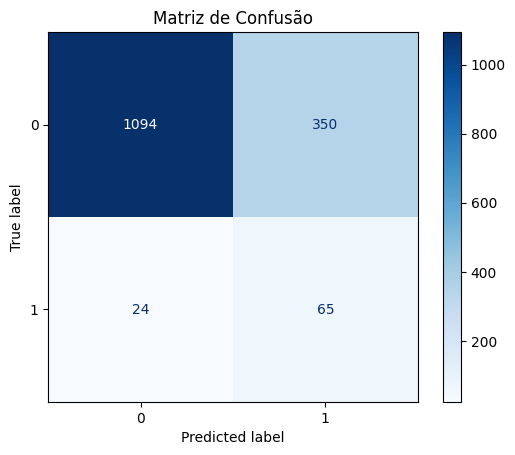

In [ ]:
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia total do modelo: {accuracy * 100:.2f}%")

Acurácia total do modelo: 75.60%


In [ ]:
tn, fp, fn, tp = cm.ravel()

# Percentuais de acerto por classe
acerto_0 = tn / (tn + fp) * 100  # Classe 0: sem AVC
acerto_1 = tp / (tp + fn) * 100  # Classe 1: com AVC (Recall)

In [ ]:
labels = ['Não teve AVC (Classe 0)', 'Teve AVC (Classe 1)']
valores = [acerto_0, acerto_1]

<ipython-input-314-4169008689>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=valores, palette='Blues_d')


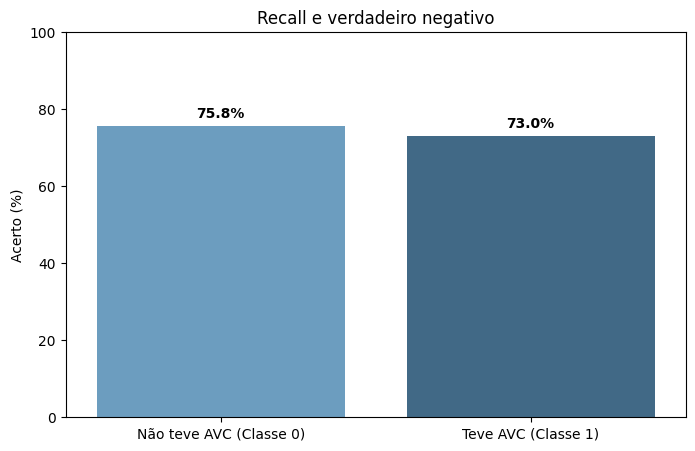

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x=labels, y=valores, palette='Blues_d')
plt.ylabel('Acerto (%)')
plt.title('Recall e verdadeiro negativo')
plt.ylim(0, 100)
for i, v in enumerate(valores):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

In [ ]:
erro_0 = fp / (tn + fp) * 100  # Classe 0: previu AVC, mas não teve AVC
erro_1 = fn / (tp + fn) * 100  # Classe 1: previu não teve AVC, mas teve AVC

In [ ]:
labels = ['Não teve AVC (Classe 0)', 'Teve AVC (Classe 1)']
valores = [erro_0, erro_1]

<ipython-input-317-2818550539>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=valores, palette='Reds')


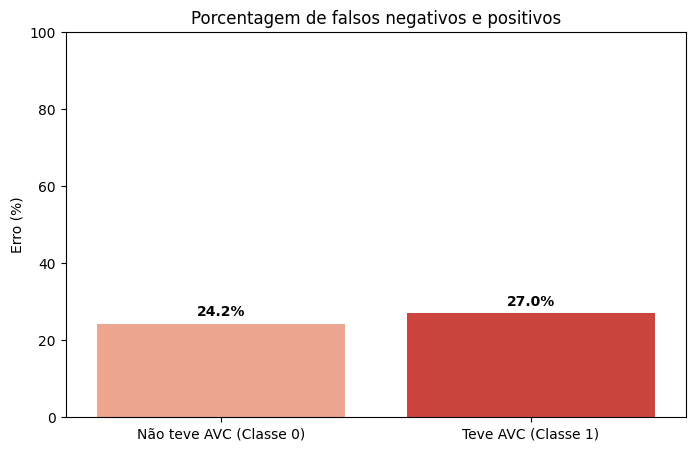

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x=labels, y=valores, palette='Reds')
plt.ylabel('Erro (%)')
plt.title('Porcentagem de falsos negativos e positivos')
plt.ylim(0, 100)
for i, v in enumerate(valores):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

In [ ]:
df_teste_original = df.loc[y_test.index].copy()

# Calcula os fatores de risco
fatores_risco = (
    df_teste_original['hypertension'].astype(int) +
    df_teste_original['heart_disease'].astype(int) +
    (df_teste_original['avg_glucose_level'] > 140).astype(int) +
    (df_teste_original['bmi'] > 30).astype(int)
)

In [ ]:
#Pessoa teve AVC e tinha ao menos 1 fator de risco
teve_avc_e_risco = (y_test == 1) & (fatores_risco >= 1)

acertou = (y_pred == 1) & teve_avc_e_risco
errou   = (y_pred == 0) & teve_avc_e_risco

total = teve_avc_e_risco.sum()
acertos_pct = (acertou.sum() / total) * 100
erros_pct = (errou.sum() / total) * 100

labels = ['Acertou', 'Errou']
valores = [acertos_pct, erros_pct]
cores = ['green', 'orange']

<ipython-input-320-1976003274>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=valores, palette=cores)


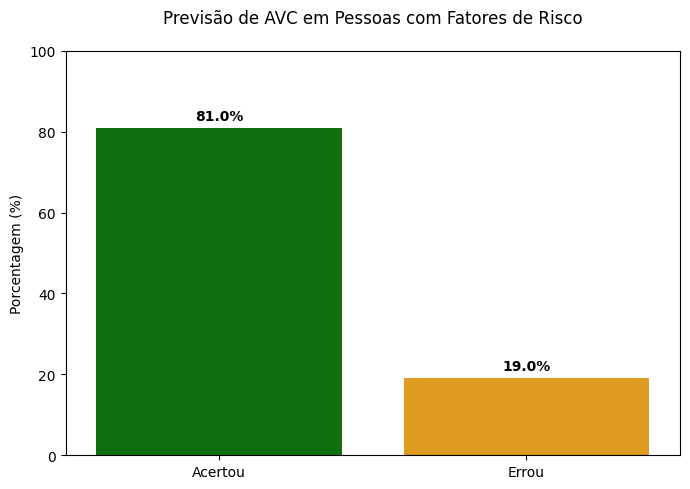

In [ ]:
plt.figure(figsize=(7, 5))
sns.barplot(x=labels, y=valores, palette=cores)
plt.ylabel('Porcentagem (%)')
plt.title('Previsão de AVC em Pessoas com Fatores de Risco', pad=20)
plt.ylim(0, 100)

for i, v in enumerate(valores):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
df_teste_original = df.loc[y_test.index].copy()

fatores_risco = (
    df_teste_original['hypertension'].astype(int) +
    df_teste_original['heart_disease'].astype(int) +
    (df_teste_original['avg_glucose_level'] > 140).astype(int) +
    (df_teste_original['bmi'] > 30).astype(int)
)

In [ ]:
# Pessoas que tiveram AVC e não tinham fatores de risco
teve_avc_sem_risco = (y_test == 1) & (fatores_risco == 0)

acertou = (y_pred == 1) & teve_avc_sem_risco
errou = (y_pred == 0) & teve_avc_sem_risco

total = teve_avc_sem_risco.sum()
acertos_pct = (acertou.sum() / total) * 100 if total > 0 else 0
erros_pct = (errou.sum() / total) * 100 if total > 0 else 0

labels = ['Acertou', 'Errou']
valores = [acertos_pct, erros_pct]
cores = ['green', 'orange']

<ipython-input-323-3427464911>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=valores, palette=cores)


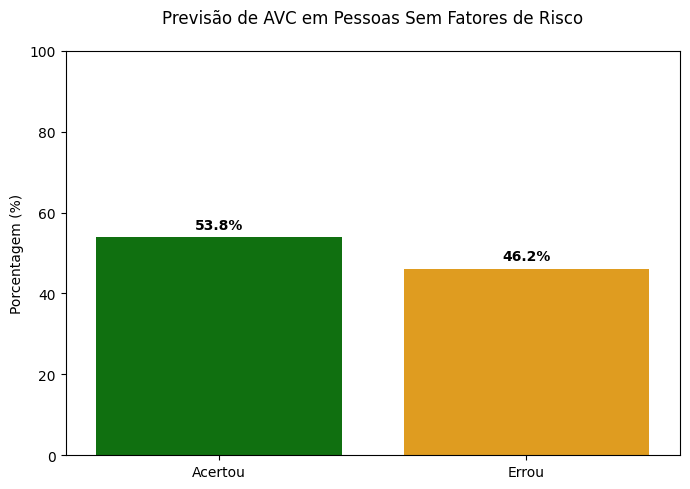

In [ ]:
plt.figure(figsize=(7, 5))
sns.barplot(x=labels, y=valores, palette=cores)
plt.ylabel('Porcentagem (%)')
plt.title('Previsão de AVC em Pessoas Sem Fatores de Risco', pad=20)
plt.ylim(0, 100)

for i, v in enumerate(valores):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()